# Analysis of comment moderation results (A/B/C policies)

This notebook:
- Loads:
  - `../data/comments.csv`
  - `../results/comments_with_policy_results.csv`
- Computes:
  - Overall distribution of decisions (BLOCK / WARN_AND_ALLOW / ALLOW) per policy
  - Average tone and debate-value scores per policy
  - Cases where policies disagree (e.g., A=BLOCK, C=ALLOW)
- Produces:
  - Summary tables (for slides / report)
  - Optional simple visualizations (bar charts) using matplotlib

Assumptions:
- Notebook is located in `notebooks/` directory of the project.
- Folder structure:

    project_root 
             
      ├─ data/ 
      
      │   └─ comments.csv 
      
      ├─ results/ 
      
      │   └─ comments_with_policy_results.csv 
      
      └─ notebooks/ 
      
          └─ analysis_comments_results.ipynb (this file) 

In [10]:
# Standard imports
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

# Set up paths assuming this notebook is in `notebooks/`
PROJECT_ROOT = Path("..").resolve()
DATA_DIR = PROJECT_ROOT / "data"
RESULTS_DIR = PROJECT_ROOT / "results"

COMMENTS_CSV = DATA_DIR / "comments.csv"
RESULTS_CSV = RESULTS_DIR / "comments_with_policy_results.csv"

print("Project root :", PROJECT_ROOT)
print("Comments CSV :", COMMENTS_CSV)
print("Results CSV  :", RESULTS_CSV)


Project root : C:\Users\Gibeom Kim\Desktop\UnderGraduate\3. junior\techno_science
Comments CSV : C:\Users\Gibeom Kim\Desktop\UnderGraduate\3. junior\techno_science\data\comments.csv
Results CSV  : C:\Users\Gibeom Kim\Desktop\UnderGraduate\3. junior\techno_science\results\comments_with_policy_results.csv


In [11]:
# Load original comments (one row per sample_id)
comments_df = pd.read_csv(COMMENTS_CSV)
print(f"Loaded {len(comments_df)} rows from comments.csv")
display(comments_df.head())

# Load policy results (one row per sample_id x policy)
results_df = pd.read_csv(RESULTS_CSV)
print(f"Loaded {len(results_df)} rows from comments_with_policy_results.csv")
display(results_df.head())


Loaded 126 rows from comments.csv


,sample_id,thread_id,role,order_in_thread,text
0,1,1,post,0,핼스장 팬티 오늘도 다른 사람이 벗어둔거 킁킁해서 기분 좋다
1,2,1,comment,1,헬스장에서 팬티를 왜 벗음
2,3,1,comment,2,게이게이야..
3,4,2,post,0,어효 코스프레하는 애들은 하나같이 젖크고 얼굴 이쁘고 빼빼 말랐네
4,5,2,comment,1,학교에 있음?


Loaded 378 rows from comments_with_policy_results.csv


,sample_id,thread_id,role,order_in_thread,policy,decision,short_reason,tone_score,debate_value_score
0,1,1,post,0,A,BLOCK,The comment implies inappropriate and invasive...,4,1
1,1,1,post,0,B,BLOCK,The comment describes inappropriate behavior t...,4,1
2,1,1,post,0,C,BLOCK,The comment depicts invasive and inappropriate...,4,1
3,2,1,comment,1,A,ALLOW,The comment is a neutral question without insu...,2,2
4,2,1,comment,1,B,ALLOW,The comment is a neutral inquiry without perso...,2,2


In [12]:
# Merge results with original text so that every row has the comment text
merged_df = results_df.merge(
    comments_df[["sample_id", "thread_id", "role", "order_in_thread", "text"]],
    on=["sample_id", "thread_id", "role", "order_in_thread"],
    how="left",
    suffixes=("", "_orig"),
)

print(f"Merged rows: {len(merged_df)}")
display(merged_df.head())


Merged rows: 378


,sample_id,thread_id,role,order_in_thread,policy,decision,short_reason,tone_score,debate_value_score,text
0,1,1,post,0,A,BLOCK,The comment implies inappropriate and invasive...,4,1,핼스장 팬티 오늘도 다른 사람이 벗어둔거 킁킁해서 기분 좋다
1,1,1,post,0,B,BLOCK,The comment describes inappropriate behavior t...,4,1,핼스장 팬티 오늘도 다른 사람이 벗어둔거 킁킁해서 기분 좋다
2,1,1,post,0,C,BLOCK,The comment depicts invasive and inappropriate...,4,1,핼스장 팬티 오늘도 다른 사람이 벗어둔거 킁킁해서 기분 좋다
3,2,1,comment,1,A,ALLOW,The comment is a neutral question without insu...,2,2,헬스장에서 팬티를 왜 벗음
4,2,1,comment,1,B,ALLOW,The comment is a neutral inquiry without perso...,2,2,헬스장에서 팬티를 왜 벗음


In [13]:
# ---- 1. Decision distribution per policy ----
decision_summary = (
    merged_df
    .groupby(["policy", "decision"])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

print("Decision counts per policy:")
display(decision_summary)

# Also compute row-wise percentages
decision_pct = decision_summary.div(decision_summary.sum(axis=1), axis=0) * 100
print("Decision percentages per policy (%):")
display(decision_pct.round(1))


Decision counts per policy:


decision,ALLOW,BLOCK,WARN_AND_ALLOW
policy,,,
A,95,26,5
B,97,13,16
C,113,6,7


Decision percentages per policy (%):


decision,ALLOW,BLOCK,WARN_AND_ALLOW
policy,,,
A,75.4,20.6,4.0
B,77.0,10.3,12.7
C,89.7,4.8,5.6


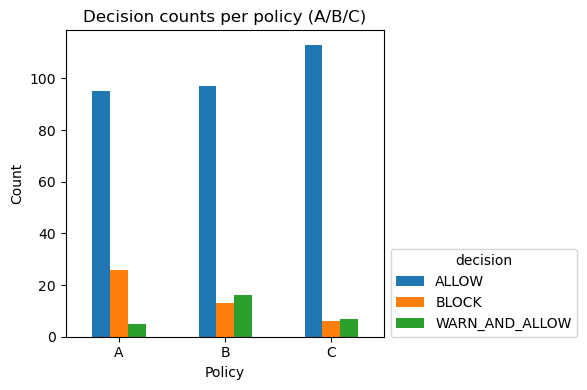

In [14]:
# Simple bar chart for decision distribution per policy
# (Uses matplotlib only, no custom colors)

ax = decision_summary.plot(
    kind="bar",
    rot=0,
    figsize=(6, 4),
)
ax.set_xlabel("Policy")
ax.set_ylabel("Count")
ax.set_title("Decision counts per policy (A/B/C)")
ax.legend(
    title="decision",    
    loc="lower left",     
    bbox_to_anchor=(1.02, 0),  
    borderaxespad=0.0,
)

plt.tight_layout()
plt.show()


Average tone_score and debate_value_score per policy:


,tone_score,debate_value_score
policy,,
A,2.02,1.54
B,2.01,1.59
C,1.99,1.59


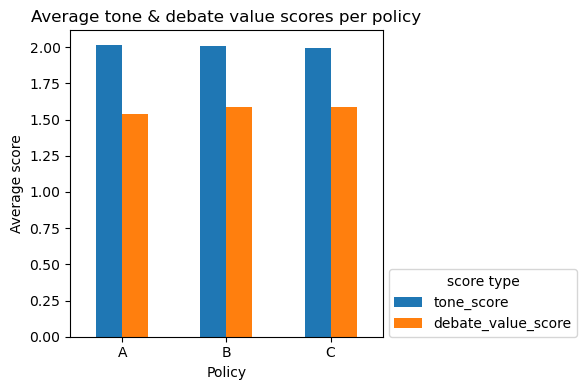

In [15]:
# ---- 2. Average scores per policy ----
score_summary = (
    merged_df
    .groupby("policy")[["tone_score", "debate_value_score"]]
    .mean()
    .sort_index()
)

print("Average tone_score and debate_value_score per policy:")
display(score_summary.round(2))

# Bar plots for scores (optional)
ax = score_summary.plot(
    kind="bar",
    rot=0,
    figsize=(6, 4),
)
ax.set_xlabel("Policy")
ax.set_ylabel("Average score")
ax.set_title("Average tone & debate value scores per policy")
ax.legend(
    title="score type",    
    loc="lower left",     
    bbox_to_anchor=(1.02, 0),  
    borderaxespad=0.0,
)

plt.tight_layout()
plt.show()


In [16]:
# ---- 3. Cases where policies disagree on decision ----
# Pivot decisions to one row per sample_id
pivot_decisions = (
    merged_df
    .pivot_table(
        index="sample_id",
        columns="policy",
        values="decision",
        aggfunc="first"
    )
    .sort_index()
)

# Filter rows where not all three policies agree
disagree_mask = pivot_decisions.nunique(axis=1) > 1
disagree_samples = pivot_decisions[disagree_mask].copy()

print(f"Number of samples where policies disagree: {len(disagree_samples)}")
display(disagree_samples.head())

# Attach original text for context
disagree_with_text = (
    disagree_samples
    .reset_index()
    .merge(
        comments_df[["sample_id", "thread_id", "role", "order_in_thread", "text"]],
        on="sample_id",
        how="left",
    )
    .sort_values("sample_id")
)

print("Disagreement cases with comment text:")
display(disagree_with_text.head(20))


Number of samples where policies disagree: 25


policy,A,B,C
sample_id,,,
4,BLOCK,BLOCK,WARN_AND_ALLOW
14,BLOCK,WARN_AND_ALLOW,ALLOW
17,BLOCK,ALLOW,ALLOW
34,BLOCK,WARN_AND_ALLOW,ALLOW
35,BLOCK,WARN_AND_ALLOW,ALLOW


Disagreement cases with comment text:


,sample_id,A,B,C,thread_id,role,order_in_thread,text
0,4,BLOCK,BLOCK,WARN_AND_ALLOW,2,post,0,어효 코스프레하는 애들은 하나같이 젖크고 얼굴 이쁘고 빼빼 말랐네
1,14,BLOCK,WARN_AND_ALLOW,ALLOW,4,post,0,과제가 공부보다 훨씬 덜 고통스럽다고 느끼는 건 아직 저학년이라서 그런 건가? 공부...
2,17,BLOCK,ALLOW,ALLOW,4,comment,3,"비슷한 거 느껴본적 있는데 년차 쌓이니까 뭐가 문제인지 깨달음. ppt만 보지말고,..."
3,34,BLOCK,WARN_AND_ALLOW,ALLOW,7,post,0,ㅈㅈㅣ팩트 일정 이상의 길이부터는 두께 강직도 지속력이 더 중요하다 반박시 섹알못
4,35,BLOCK,WARN_AND_ALLOW,ALLOW,7,comment,1,그니까 너가 딱 평균이란 거지?
5,37,WARN_AND_ALLOW,WARN_AND_ALLOW,ALLOW,8,comment,1,대가 이상한거는 뭐임
6,39,BLOCK,BLOCK,WARN_AND_ALLOW,9,post,0,자지 17센치면 상위 몇? 10가능?
7,41,BLOCK,BLOCK,WARN_AND_ALLOW,9,comment,2,갸 좆밥인대
8,42,WARN_AND_ALLOW,WARN_AND_ALLOW,ALLOW,9,comment,3,Ak 17 glock 이면 ㅈㅂ까진 아니지 않나?
9,53,BLOCK,WARN_AND_ALLOW,ALLOW,11,post,0,수위 높은 우울한 얘기 들어볼사람 무려 우울증 커뮤니티에서도 밴 당한 내용임 딱 두...


In [17]:
# Save disagreement cases to CSV for convenient use in slides / report
disagree_path = RESULTS_DIR / "disagreement_cases_with_text.csv"
disagree_with_text.to_csv(disagree_path, index=False, encoding="utf-8-sig")

print("Saved disagreement cases to:", disagree_path)


Saved disagreement cases to: C:\Users\Gibeom Kim\Desktop\UnderGraduate\3. junior\techno_science\results\disagreement_cases_with_text.csv


In [18]:
# ---- 4. (Optional) Thread-level overview ----
# For each thread, show how many comments are blocked vs allowed under each policy.

thread_policy_summary = (
    merged_df
    .groupby(["thread_id", "policy", "decision"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
    .sort_values(["thread_id", "policy"])
)

print("Thread-level decision distribution:")
display(thread_policy_summary.head(20))

# This can be exported too if needed
thread_summary_path = RESULTS_DIR / "thread_policy_summary.csv"
thread_policy_summary.to_csv(thread_summary_path, index=False, encoding="utf-8-sig")
print("Saved thread-level summary to:", thread_summary_path)


Thread-level decision distribution:


decision,thread_id,policy,ALLOW,BLOCK,WARN_AND_ALLOW
0,1,A,1,2,0
1,1,B,1,2,0
2,1,C,1,2,0
3,2,A,3,1,0
4,2,B,3,1,0
5,2,C,3,0,1
6,3,A,6,0,0
7,3,B,6,0,0
8,3,C,6,0,0
9,4,A,10,2,0


Saved thread-level summary to: C:\Users\Gibeom Kim\Desktop\UnderGraduate\3. junior\techno_science\results\thread_policy_summary.csv
